# Project 4 - introduction

## 1. Первичная обработка данных


### Исходные данные:

### Данные о клиентах банка:

- age (возраст);
- job (сфера занятости);
- marital (семейное положение);
- education (уровень образования);
- default (имеется ли просроченный кредит);
- housing (имеется ли кредит на жильё);
- loan (имеется ли кредит на личные нужды);
- balance (баланс).

### Данные, связанные с последним контактом:

- contact (тип контакта с клиентом);
- month (месяц, в котором был последний контакт);
- day (день, в который был последний контакт);
- duration (продолжительность контакта в секундах).

### Прочие признаки:

- campaign (количество контактов с этим клиентом в течение текущей кампании);
- pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- previous (количество контактов до текущей кампании)
- poutcome (результат прошлой маркетинговой кампании).

### Целевой признак:

- deposit.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import statistics as st
import optuna
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.metrics import classification_report

### Задание 2.1
В каком признаке пропущенных значений больше всего?

In [2]:
df = pd.read_csv('D:\IDE\Project 4\Data/bank_fin.csv', sep = ';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [3]:
df_nulls = df.isnull().sum()
nulls = df_nulls[df_nulls > 0]
print('Признаки и количество пропущенных значений:\n{}'.format(nulls))

Признаки и количество пропущенных значений:
balance    25
dtype: int64


### Задание 2.2
Введите слово, которым закодированы пропуски (неизвестные значения)

In [4]:
df.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
11157,33,blue-collar,single,primary,no,"1,00 $",yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,"733,00 $",no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,"29,00 $",no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0 $,no,yes,cellular,8,may,9,2,172,5,failure,no
11161,34,technician,married,secondary,no,0 $,no,no,cellular,9,jul,628,1,-1,0,unknown,no


Как видно из таблицы, это слово "unknown"

### Задание 2.3
Вычислите среднее значение по преобразованному в корректный вид признаку balance. Ответ округлите до трёх знаков после точки-разделителя

In [5]:
def make_convert(row):
    row = str(row)
    if row != 'unknown':
        row = row.replace(',00', '')
        row = row.replace('$', '')
        row = row.replace(' ', '')
        return float(row)
    else:
        return np.nan

df['balance'] = df['balance'].apply(make_convert)
print('Cреднее значение по преобразованному в корректный вид признаку balance:\n{}'.format((round(df['balance'].mean(), 3))))

Cреднее значение по преобразованному в корректный вид признаку balance:
1529.129


### Задание 2.4
Вычислите среднее значение по преобразованному в корректный вид признаку balance. Ответ округлите до трёх знаков после точки-разделителя.

In [6]:
df['balance'] = df['balance'].fillna(df['balance'].median())
print('Cреднее значение по преобразованному в корректный вид признаку balance:\n{}'.format((round(df['balance'].mean(), 3))))

Cреднее значение по преобразованному в корректный вид признаку balance:
1526.936


### Задание 2.5
После замены пропусков рассчитайте средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования (т. е. для тех, у кого одновременно самая популярная работа и самое популярное образование). Ответ округлите до трёх знаков после точки-разделителя.

In [7]:
df['job'] = df['job'].replace(['unknown'], 'management')
df['education'] = df['education'].replace(['unknown'], 'secondary')
df_new = df[(df['job'] == 'management') & (df['education'] == 'secondary')]
print('Cреднее значение по признаку balance, после преобразования:\n{}'.format((round(df_new['balance'].mean(), 3))))

Cреднее значение по признаку balance, после преобразования:
1598.883


### Задание 2.6 и 2.7
Изучите признак, отображающий баланс клиентов, на предмет выбросов.

In [8]:
ar = np.percentile(df['balance'], [25,75])
df_q = pd.DataFrame(ar)

x = df['balance']
q_1 = df_q[0][0]
q_3 = df_q[0][1]

irq = q_3 - q_1
lower_bound = q_1 - (irq*1.5)
upper_bound = q_3 + (irq*1.5)

# Анализ выбросов меодом Тьюки (строгое неравенство)
outliers = df[(x < lower_bound) | (x > upper_bound)]

# Анализ выбросов меодом Тьюки (нестрогое неравенство)
cleaned = df[(x >= lower_bound) & (x <= upper_bound)]

print(f'Нижний квартиль (25), найденный с помощью функции percentile: {q_1}')
print(f'Верхний квартиль (75), найденный с помощью функции percentile: {q_3}')
print(f'Нижняя граница выбросов: {round(lower_bound)}')
print(f'Верхняя граница выбросов: {round(upper_bound)}')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'После удаления выбросов осталось {cleaned.shape[0]} объектов')

Нижний квартиль (25), найденный с помощью функции percentile: 123.0
Верхний квартиль (75), найденный с помощью функции percentile: 1699.0
Нижняя граница выбросов: -2241
Верхняя граница выбросов: 4063
Число выбросов по методу Тьюки: 1057
После удаления выбросов осталось 10105 объектов


## 2. Разведывательный анализ данных (EDA)


### Задание 3.1
Сколько клиентов открыли депозит?

Количество клиентов у которых есть депозит: 4681


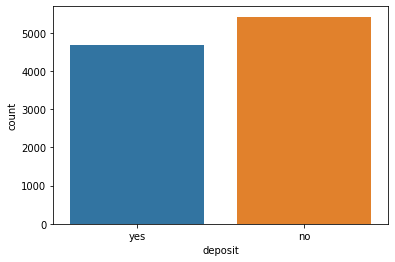

In [9]:
df = df.drop(outliers.index, axis=0) #удаяем выбросы

sns.countplot(data=df, x='deposit')

deposit = df[(df['deposit'] == 'yes')]
print('Количество клиентов у которых есть депозит:', deposit.shape[0])

Как видно по классу "депозит" выборка сбалансирована

### Задание 3.2
Какой максимальный возраст клиента банка?

Максимальный возраст клиента банка: 95


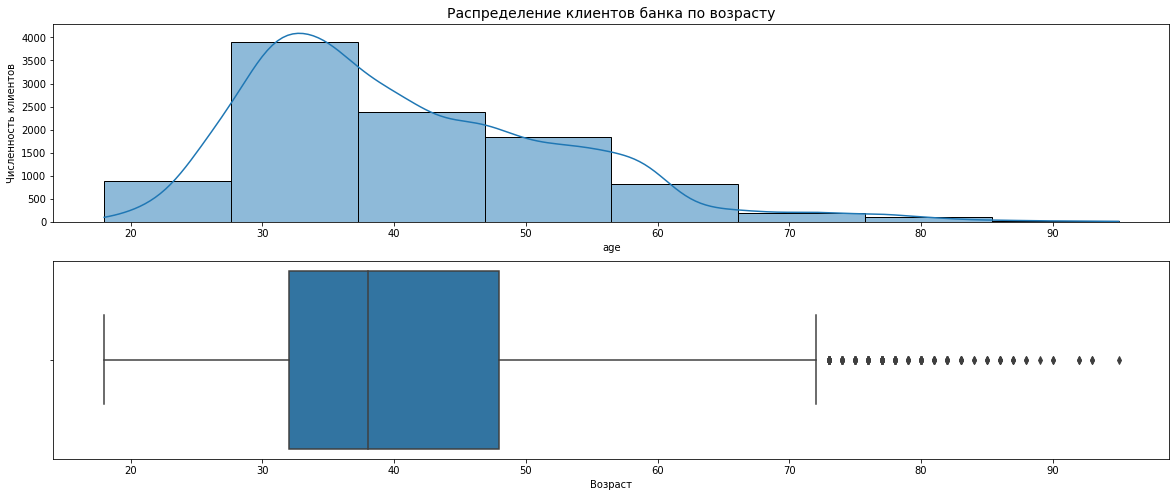

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 8))
sns.histplot(
    data=df,
    x='age',
    bins=8,
    kde=True,
    ax=axes[0]
)
axes[0].set_title('Распределение клиентов банка по возрасту', fontsize=14)
axes[0].set_ylabel('Численность клиентов')
sns.boxplot(
    data=df,
    x='age',
    orient='h',
    width=0.9
)
axes[1].set_xlabel('Возраст')
print('Максимальный возраст клиента банка:', df['age'].max())

### Задание 3.3
Какая минимальная продолжительность разговора с клиентом банка?

Минимальная продолжительность разговора с клиентом банка, сек: 2


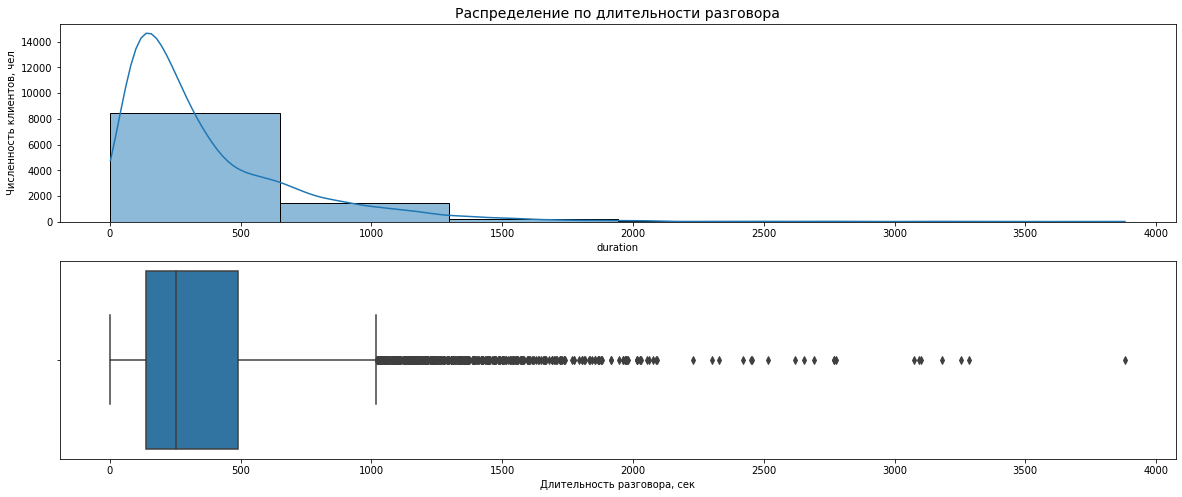

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 8))
sns.histplot(
    data=df,
    x='duration',
    bins=6,
    kde=True,
    ax=axes[0]
)
axes[0].set_title('Распределение по длительности разговора', fontsize=14)
axes[0].set_ylabel('Численность клиентов, чел')
sns.boxplot(
    data=df,
    x='duration',
    orient='h',
    width=0.9
)
axes[1].set_xlabel('Длительность разговора, сек')

print('Минимальная продолжительность разговора с клиентом банка, сек:', df['duration'].min())

### Задание 3.4
Сколько было месяцев, в которых проводилась маркетинговая кампания?

Text(0.5, 1.0, 'Распределение клиентов по месяцам проведения рекламной кампании')

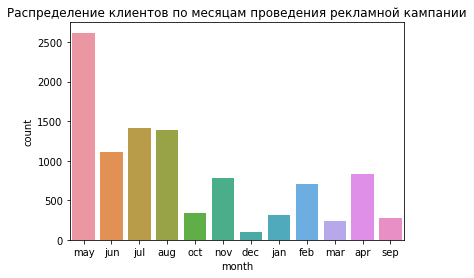

In [12]:
cp1 = sns.countplot(data=df, x='month')
cp1.axes.set_title("Распределение клиентов по месяцам проведения рекламной кампании")

Как видно из гистограммы, в каждом месяце проводилась маркетинговая кампания

### Задание 3.5 и 3.9
Сколько сфер занятости представлено среди клиентов банка?
В какой сфере занято наибольшее число клиентов банка?

Text(0.5, 1.0, 'Распределение клиентов по сферам деятельности')

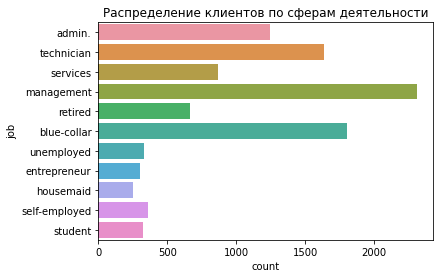

In [13]:
cp2 = sns.countplot(data=df, y='job')
cp2.axes.set_title("Распределение клиентов по сферам деятельности")

Всего представлено 11 сфер занятости. Наиболее распространенная - управление

### Задание 3.6
Напишите значение статуса предыдущей кампании, для которой в текущей успехов намного больше, чем неудач.

Значения статуса предыдущей кампании - это признак poutcome. Нужно посчитать количество значений целевой переменной, относящиеся к значениям poutcome.

Итоги прошлой маркетинговой кампании, чел:
 deposit  poutcome
no       unknown     4562
         failure      562
         other        216
         success       84
yes      unknown     3008
         success      861
         failure      547
         other        265
Name: poutcome, dtype: int64


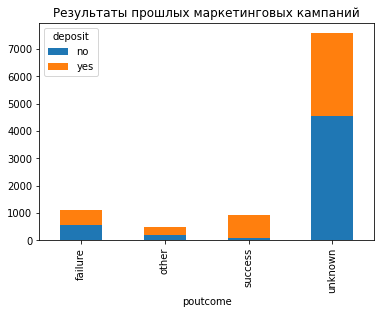

In [14]:
# Используем группировку 'deposit' по индексу 'poutcome'

types = df.groupby("poutcome")['deposit'].value_counts(normalize=False).unstack()
cp3 = types.plot(kind='bar', stacked='True')
cp3.axes.set_title("Результаты прошлых маркетинговых кампаний")

print('Итоги прошлой маркетинговой кампании, чел:\n', df.groupby("deposit")['poutcome'].value_counts())


Признаком (значением успеха) является "success"

### Задание 3.7
Рассчитайте, в каком месяце самый большой процент неудач при взаимодействии в текущей маркетинговой кампании. Возможно, этот месяц не является подходящим для проведения подобных акций, и это стоит отметить. Введите название месяца латиницей ровно так, как месяц обозначен в данных.

In [15]:
temp = df.groupby(['month'])['deposit'].value_counts(normalize=True,
                                                       sort=False)
temp = pd.DataFrame(temp)
temp.columns = ['deposit_count']
temp.reset_index(level='deposit', inplace=True)
display(temp[temp['deposit'] == 'no']['deposit_count'].sort_values())
print('Месяц с самым большим % неудач, при взаимодействии в текущей маркетинговой кампании:\n',
      temp[temp['deposit'] == 'no']['deposit_count'].sort_values().index[-1])


month
dec    0.096774
mar    0.101266
sep    0.165468
oct    0.185075
apr    0.381928
feb    0.455571
jun    0.548913
aug    0.559567
nov    0.584615
jul    0.589563
jan    0.608150
may    0.678640
Name: deposit_count, dtype: float64

Месяц с самым большим % неудач, при взаимодействии в текущей маркетинговой кампании:
 may


### Задание 3.8
Выберите из списка две возрастные группы, которые более склонны открывать депозит, чем отказываться от открытия депозита в банке после рекламного предложения.

Text(0.5, 1.0, 'Распределение клиентов по возрасту')

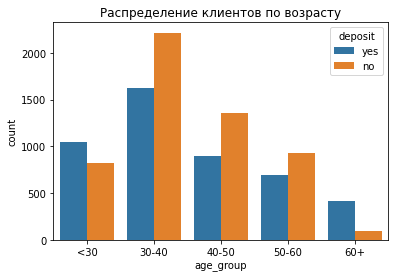

In [16]:
# Для создания категорий используем метод cut()

#df_a = df.copy()
df['age_group'] = pd.cut(df.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])

cp4 = sns.countplot(x="age_group", hue="deposit", data=df)
cp4.axes.set_title("Распределение клиентов по возрасту")

Как видно из гистограммы распределения клиентов по возрастам, по результатам маркетингововых кампаний чаще всего открывали депозит люди до 30 и старше 60 лет.

### Задание 3.10
При каком семейном положении есть тенденция открывать депозит, а не отказываться от его открытия?

Text(0.5, 1.0, 'Распределение клиентов по семейному положению')

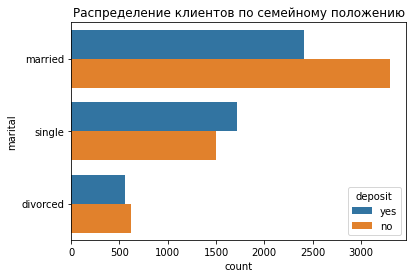

In [17]:
cp5 = sns.countplot(y='marital', hue='deposit', data=df)
cp5.axes.set_title("Распределение клиентов по семейному положению")

Склонностью к открытию депозитов чаще "страдают" одинокие люди

### Задание 3.11
Каких людей среди открывших депозит больше: одиноких с высшим образованием или разведённых с более низким уровнем образования?
Пересечение каких двух категорий является самым многочисленным?

marital    divorced  married  single
education                           
primary          96      339      82
secondary       283     1289     879
tertiary        174      784     755


Text(0.5, 1.0, 'Тепловая карта зависимости открытия депозина от семейного положения и образования клиентов')

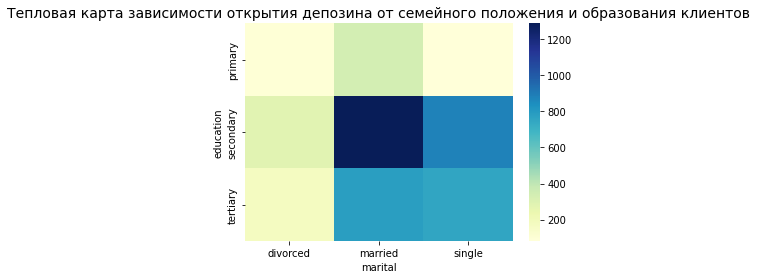

In [18]:
# Для начала отфильтруем в отдельные таблицы тех, кто согласился открыть депозит, и тех, кто не согласился.
# После этого составем сводные таблицы и визуализируйте их с помощью тепловых карт.
deposit_yes = df[df.deposit=='yes']
deposit_no = df[df.deposit=='no']
ctt_table = pd.crosstab(deposit_yes.education, deposit_yes.marital)
print(ctt_table)
heatmap = sns.heatmap(
    data=ctt_table,
    cmap='YlGnBu')
heatmap.set_title('Тепловая карта зависимости открытия депозина от семейного положения и образования клиентов', fontsize=14)

Как видно из таблицы и тепловой карты, чаще всего открывают депозит семейные клиенты со средним образованием

## 3. Отбор и преобразование признаков


Начнём с обработки категориального порядкового признака, который отвечает за уровень образования: education.
Обработаем его с помощью метода LabelEncoder, используя метод без дополнительных настроек.

### Задание 4.1
Найдите сумму получившихся значений для признака education.

In [19]:
# Создание экземпляра класса LabelEncoder()
le = LabelEncoder()

# Кодирование признака
df['education'] = le.fit_transform(df['education'])
df["age_group"] = le.fit_transform(df["age_group"])
print('Cумма значений для признака education:', df['education'].sum())

Cумма значений для признака education: 11995


Ранее мы создали порядковую переменную для возраста. Обработаем её по такому же принципу, чтобы её можно было использовать при обучении модели.
Затем сделаем то же самое для других бинарных переменных, которых у нас три:

'default';
'housing';
'loan'.
Все три мы будем модифицировать ровно так же: для слова yes мы возьмём в качестве значения 1, а для no — 0.

### Задание 4.2, 4.3
Вычислите стандартное отклонение по преобразованной в корректный вид целевой переменной deposit. Ответ округлите до трёх знаков после точки-разделителя.

In [20]:
df['deposit'] = df['deposit'].apply(lambda x: 1 if x=='yes' else 0)
df['default'] = df['default'].apply(lambda y: 1 if y=='yes' else 0)
df['housing'] = df['housing'].apply(lambda z: 1 if z=='yes' else 0)
df['loan'] = df['loan'].apply(lambda u: 1 if u=='yes' else 0)

print(f"Стандартное отклонение преобразованной в корректный вид переменной deposit:\
     {round(st.stdev(df['deposit']), 3)}")
print(f"Сумма средних арифметических default, housing, loan: \
    {round(st.mean(df['default'])+st.mean(df['housing'])+st.mean(df['loan']), 3)}")

Стандартное отклонение преобразованной в корректный вид переменной deposit:     0.499
Сумма средних арифметических default, housing, loan:     0.635


### Задание 4.4

Сколько теперь всего признаков в датасете, не считая целевую переменную? Введите ответ, посчитав уже добавленные dummy-переменные, но до удаления номинальных.

In [21]:
df = pd.get_dummies(df)
df.columns
# Пояснение от методолога проекта: некоторые кодировщики могут удалить признаки после кодировки. Получается, что 'job', 'marital', 'contact', 'month', 
# 'poutcome' могут быть удалены из исходного датафрейма. Если сложить 46 + 5, то получим 51, где 'deposit' не в счёт. В итоге, правильный ответ 50.

Index(['age', 'education', 'default', 'balance', 'housing', 'loan', 'day',
       'duration', 'campaign', 'pdays', 'previous', 'deposit', 'age_group',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')

### Задание 4.5 и 4.6
Расставьте признаки, в наибольшей степени коррелирующие с целевой переменной, по убыванию силы линейной взаимосвязи.
Есть ли среди признаков мультиколлинеарность? Будем считать достаточно сильной корреляцию не менее 0.9.

In [22]:
df.nunique(dropna=False)

age                    76
education               3
default                 2
balance              2963
housing                 2
loan                    2
day                    31
duration             1390
campaign               35
pdays                 458
previous               30
deposit                 2
age_group               5
job_admin.              2
job_blue-collar         2
job_entrepreneur        2
job_housemaid           2
job_management          2
job_retired             2
job_self-employed       2
job_services            2
job_student             2
job_technician          2
job_unemployed          2
marital_divorced        2
marital_married         2
marital_single          2
contact_cellular        2
contact_telephone       2
contact_unknown         2
month_apr               2
month_aug               2
month_dec               2
month_feb               2
month_jan               2
month_jul               2
month_jun               2
month_mar               2
month_may   

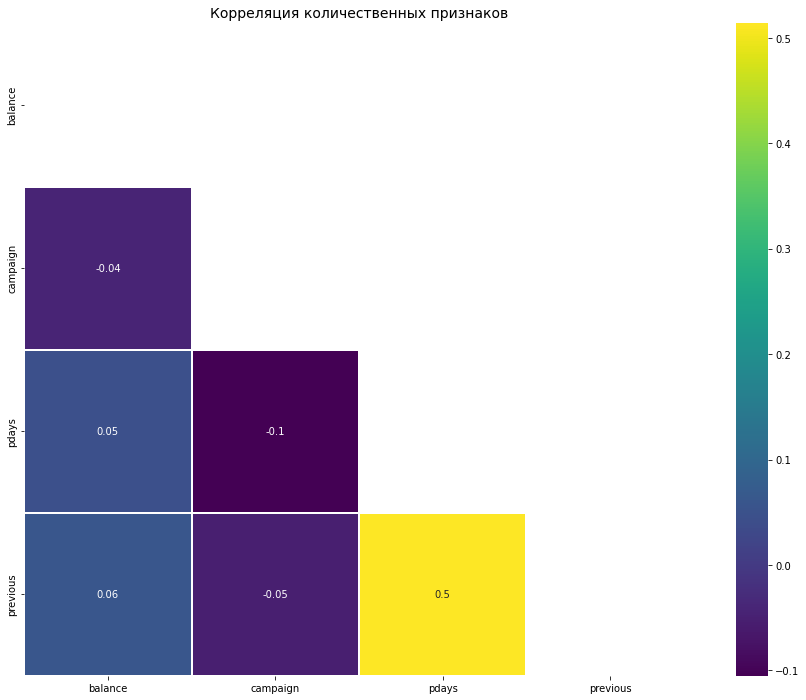

In [23]:
#Разделим признаки по типу
#Количественные
cols_num = [
    'balance',
    'campaign',
    'pdays',
    'previous',
    ]
#Категориальные
cols_cat = [
    'age_group',
    'education',
    'default',
    'housing',
    'loan',
    'day',
    'duration',
    'deposit',
    'job_admin.',
    'job_blue-collar',
    'job_entrepreneur',
    'job_housemaid',
    'job_management',
    'job_retired',
    'job_self-employed',
    'job_services',
    'job_student',
    'job_technician',
    'job_unemployed',
    'marital_divorced',
    'marital_married',
    'marital_single',
    'contact_cellular',
    'contact_telephone',
    'contact_unknown',
    'month_apr',
    'month_aug',
    'month_dec',
    'month_feb',
    'month_jan',
    'month_jul',
    'month_jun',
    'month_mar',
    'month_may',
    'month_nov',
    'month_oct',
    'month_sep',
    'poutcome_failure',
    'poutcome_other',
    'poutcome_success',
    'poutcome_unknown'
]
#Построим тепловую диаграмму корреляции количественных признаков
fig_, ax_ = plt.subplots(figsize=(15, 12))
corr = df[cols_num].corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, 
            annot=True, 
            linewidths=0.1, 
            ax=ax_, 
            mask=mask, 
            cmap='viridis',
            fmt='.1g')
ax_.set_title('Корреляция количественных признаков', fontsize=14)
plt.show()

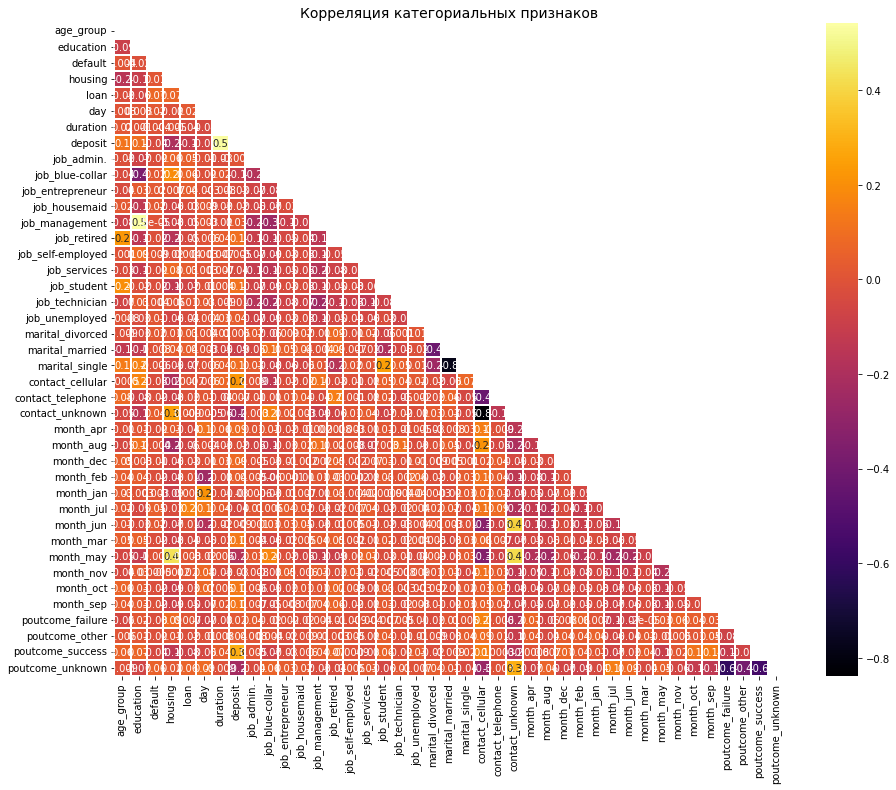

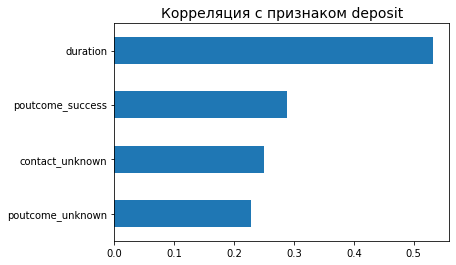

In [24]:
#Построим тепловую диаграмму корреляции категориальных признаков
fig_, ax_ = plt.subplots(figsize=(15, 12))
corr = df[cols_cat].corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, 
            annot=True, 
            linewidths=0.1, 
            ax=ax_, 
            mask=mask, 
            cmap='inferno',
            fmt='.1g')
ax_.set_title('Корреляция категориальных признаков', fontsize=14)
plt.show()

corr["deposit"].apply(lambda x: abs(x)).sort_values()[-5:-1].plot.barh()
plt.title("Корреляция с признаком deposit", fontsize = 14)
plt.show()

Из графиков видно, что мультиколлинеарность отсутствует

### Задание 4.7 и 4.8
Теперь определим целевую переменную ("deposit") и предикторы, а также разделим выборку на обучающую и тестовую.
При разбиении задайте параметр random_state = 42, а размер тестовой выборки возьмите за 0.33.

Каким получился размер тестовой выборки?

Каково среднее значение целевой переменной на тестовой выборке? Ответ округлите до двух знаков после точки-разделителя.

In [25]:
y = df['deposit']
x = df.drop(columns='deposit', axis=1)
X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.33, random_state=42)
print(f'Размерность тестовой выборки {X_test.shape}')
print('Cреднее значение целевой переменной: {}'.format((round(y_test.mean(), 2))))

Размерность тестовой выборки (3335, 45)
Cреднее значение целевой переменной: 0.46


### Задание 4.9
На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.

С помощью SelectKBest отберите 15 признаков, наилучшим образом подходящих для использования в задаче. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_classif.

In [26]:
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
 
selector.get_feature_names_out()
# Обязательно контролируем признаки, которые были отобраны SelectKBest (15 признаков)

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

['balance',
 'housing',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'age_group',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

### Задание 4.10
Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из тестовой выборки. Ответ округлите до двух знаков после точки-разделителя.

In [27]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)                           # fit() только на train данных
X_train_scaled = scaler.transform(X_train)    # fransform() на train данных
X_test_scaled = scaler.transform(X_test)      # fransform() на test данных

print(round(X_test_scaled[:, 0].mean(), 2))  # для признака balance

0.31


## 4. Решение задачи классификации: логистическая регрессия и решающие деревья

Общая информация. Полученные метрики могут иметь небольшое расхождение с результатами ответов на платформе (~0.1-0.3). Объясняется это выбором версии sklearn.  

### Задание 5.1
Для получившейся модели вычислите значение accuracy на тестовой выборке. Ответ округлите до двух знаков после точки-разделителя.

In [32]:
log_reg = linear_model.LogisticRegression(
    solver='sag', 
    random_state=42, 
    max_iter=1000 )

log_reg.fit(X_train_scaled, y_train)
y_train_pred = log_reg.predict(X_train_scaled)
y_pred = log_reg.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1790
           1       0.82      0.77      0.80      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 5.2
Что можно наблюдать после реализации алгоритма и оценки его качества?

In [33]:
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth = 6
)

dt.fit(X_train_scaled, y_train)

y_train_pred = dt.predict(X_train_scaled)
y_pred = dt.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.77      0.81      1790
           1       0.76      0.84      0.80      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.81      0.80      3335
weighted avg       0.81      0.80      0.80      3335



### Задание 5.3 и 5.4
Какое наибольшее значение accuracy у вас получилось? Ответ округлите до двух знаков после точки-разделителя.

Какую максимальную глубину дерева вы задали?

In [ ]:
grid_search_params = {'max_depth': range(1, 20)}
grid_search_estimator = tree.DecisionTreeClassifier(criterion='entropy',
                                                    random_state=42)
grid_search = GridSearchCV(
    estimator=grid_search_estimator,
    param_grid=grid_search_params,
    n_jobs=-1
)
grid_search.fit(X_train_scaled, y_train)

y_train_pred = grid_search.predict(X_train_scaled)
y_pred = grid_search.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_pred))

grid_search.best_params_

              precision    recall  f1-score   support

           0       0.84      0.79      0.81      1790
           1       0.77      0.83      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



{'max_depth': 9}

### Задание 5.5
Оцените метрику F1 на тестовой выборке для наилучшей комбинации перебираемых параметров. В качестве ответа впишите значение метрики. Ответ округлите до двух знаков после точки-разделителя.

In [ ]:
parameters =  {'min_samples_split': [2, 5, 7, 10], 'max_depth':[3,5,7]}

model_cv = GridSearchCV(tree.DecisionTreeClassifier(random_state=42,
                                                    criterion='entropy'), 
                        parameters,
                        cv=3,
                        scoring='f1', 
                        return_train_score=True)

model_cv.fit(X_train_scaled, y_train)

y_train_pred = model_cv.predict(X_train_scaled)
y_pred = model_cv.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.81      0.82      1790
           1       0.79      0.82      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.82      0.81      0.81      3335



## 5. Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 6.1
Оцените метрики accuracy и recall для построенной модели на тестовой выборке. В качестве ответов введите значения метрик. Ответ округлите до двух знаков после точки-разделителя.

In [ ]:
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
#Обучаем модель
rf.fit(X_train_scaled, y_train)

y_train_pred = rf.predict(X_train_scaled)
y_pred = rf.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 6.2
Сравним полученные результаты с моделью градиентного бустинга. Используйте градиентный бустинг для решения задачи классификации, задав для него следующие параметры:

learning_rate = 0.05;
n_estimators = 300;
min_samples_leaf = 5;
max_depth = 5;
random_state = 42.

Для построенной модели оцените метрику F1 на тестовой выборке. В качестве ответа впишите значение метрики. Ответ округлите до двух знаков после точки-разделителя.

In [ ]:
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gb.fit(X_train_scaled, y_train)

y_train_pred = gb.predict(X_train_scaled)
y_pred = gb.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 6.4
В этом задании нам необходимо использовать стекинг, объединив те алгоритмы, которые вы уже использовали ранее: решающие деревья, логистическую регрессию и градиентный бустинг. В качестве метамодели используйте модель логистической регрессии.

Параметры оставьте те же, что были в ваших алгоритмах в предыдущих заданиях.

Для построенной модели оцените метрику precision на тестовой выборке. В качестве ответа впишите значение метрики. Ответ округлите до двух знаков после точки-разделителя.

In [ ]:
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42 
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
stack.fit(X_train_scaled, y_train)

y_train_pred = stack.predict(X_train_scaled)
y_pred = stack.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 6.6
Один из более продвинутых вариантов оптимизации гиперпараметров — фреймворк Optuna. Применим его для оптимизации гиперпараметров. Для перебора возьмем случайный лес и следующие параметры:

n_estimators = trial.suggest_int('n_estimators', 100, 200, 1);

max_depth = trial.suggest_int('max_depth', 10, 30, 1);

min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1).

Введите значение метрики F1 на тестовой выборке. Ответ округлите до двух знаков после точки-разделителя.

In [ ]:
def optuna_rf(trial) -> float:
    """
    Задаёт пространство гиперпараметров и обучает метамодель.
    Возвращает F-меру на обучающей выборке. Нежизнеспособным
    комбинациям присваивается нулевое значение.
    """
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    rf = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                            max_depth=max_depth,
                                            min_samples_leaf=min_samples_leaf,
                                            n_jobs=-1,
                                            random_state=42)

    rf.fit(X_train_scaled, y_train)
    score = metrics.f1_score(y_test, rf.predict(X_test_scaled))
    return score


study_rf = optuna.create_study(study_name='RandomForest',
                                  direction="maximize")
study_rf.optimize(optuna_rf, n_trials=20, n_jobs=-1)
study_rf.best_params, study_rf.best_value

[I 2022-10-22 23:47:59,940] A new study created in memory with name: RandomForest
[I 2022-10-22 23:48:03,434] Trial 5 finished with value: 0.8173747622067217 and parameters: {'n_estimators': 110, 'max_depth': 10, 'min_samples_leaf': 3}. Best is trial 5 with value: 0.8173747622067217.
[I 2022-10-22 23:48:03,485] Trial 9 finished with value: 0.8143674507310871 and parameters: {'n_estimators': 116, 'max_depth': 10, 'min_samples_leaf': 8}. Best is trial 5 with value: 0.8173747622067217.
[I 2022-10-22 23:48:03,549] Trial 11 finished with value: 0.8157061431285624 and parameters: {'n_estimators': 121, 'max_depth': 17, 'min_samples_leaf': 9}. Best is trial 5 with value: 0.8173747622067217.
[I 2022-10-22 23:48:03,772] Trial 3 finished with value: 0.8137317228226318 and parameters: {'n_estimators': 131, 'max_depth': 28, 'min_samples_leaf': 10}. Best is trial 5 with value: 0.8173747622067217.
[I 2022-10-22 23:48:04,070] Trial 6 finished with value: 0.8139461172741679 and parameters: {'n_estimato

({'n_estimators': 196, 'max_depth': 23, 'min_samples_leaf': 3},
 0.8225298930144745)

### Задание 6.7
Введите значение метрики accuracy на тестовой выборке. Ответ округлите до двух знаков после точки-разделителя.

In [ ]:
rf_2 = ensemble.RandomForestClassifier(n_estimators=176,
                                        max_depth=17,
                                        min_samples_leaf=3,
                                        random_state=42)
rf_2.fit(X_train_scaled, y_train)
y_test_predict_2 = rf_2.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_predict_2))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1790
           1       0.80      0.85      0.83      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.84      0.83      0.83      3335

